In [181]:
#pip install vaderSentiment

# PROJECT NAME

### PROJECT MEMBERS

In [182]:
#Research Question and Background
#Hypothesis

# Overall question
- Does emotion(postive/negative) influence reaction time
    - fear
- Does isolation affect emotion
- Emotion and memory
    - Happy, sad, fear, sentimental, bored, depression
    - Does music help
    - Does being happy/sad/mad help
    - Enviornment 
        - Loction of learning, learning at school Environment help retain knowledge 
            -Does the emotion in that environment affect it
        - How well can people adapt to forced learning measures
        - 
     - Does body posture affect memory
     - Do drugs imporve memory
         - Does time of consumtion matter
     - 
             
    
- Emotion and music

# Emotions that we want to look at:
- FEAR
- ANGER
- SADNESS
- SENTIMENTAL

# Regions in the brain we want to look at:
- Amygdala
- Temporal lobe
- Prefrontal Cortex
- Hippocampus


# I. Set Up

In [183]:
from lisc import Counts
from lisc.utils.db import SCDB
from lisc.plts.counts import *
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Data Import
hippDf = pd.read_csv('hippoCorpusV2.csv')
islandersDf = pd.read_csv('Islander_data.csv')

### 1a. Text Mining

In [184]:
#First term list we are searching for
terms_a = [['"fear"'], ['"anger"'], ['"sadness"'], ['"sentimental"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts = Counts()
counts.add_terms(terms_a)

# Collect data using the run_collection method
counts.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts.check_counts()

Running counts for:  "fear"
Running counts for:  "anger"
Running counts for:  "sadness"
Running counts for:  "sentimental"
The number of documents found for each search term is:
  '"fear"'          -   76067
  '"anger"'         -   16773
  '"sadness"'       -    6468
  '"sentimental"'   -     236


In [185]:
counts.counts

array([[   0, 2976, 1956,   11],
       [2976,    0, 2420,    4],
       [1956, 2420,    0,    2],
       [  11,    4,    2,    0]])

In [186]:
#Second term list we are searching for
terms_b = [['"amygdala"'], ['"temporal lobe"'], ['"prefrontal cortex"'], ['"hippocampus"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts2 = Counts()
counts2.add_terms(terms_b)

# Collect data using the run_collection method
counts2.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts2.check_counts()

Running counts for:  "amygdala"
Running counts for:  "temporal lobe"
Running counts for:  "prefrontal cortex"
Running counts for:  "hippocampus"
The number of documents found for each search term is:
  '"amygdala"'            -    38280
  '"temporal lobe"'       -    34556
  '"prefrontal cortex"'   -    52548
  '"hippocampus"'         -   119619


In [187]:
counts2.counts

array([[    0,  2287,  6600, 11843],
       [ 2287,     0,  1659,  6509],
       [ 6600,  1659,     0,  8860],
       [11843,  6509,  8860,     0]])

In [188]:
#Third term list we are searching for
terms_c = [['"amygdala"'], ['"hippocampus"'],['"fear"'], ['"anger"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts3 = Counts()
counts3.add_terms(terms_c)

# Collect data using the run_collection method
counts3.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts3.check_counts()

Running counts for:  "amygdala"
Running counts for:  "hippocampus"
Running counts for:  "fear"
Running counts for:  "anger"
The number of documents found for each search term is:
  '"amygdala"'      -    38280
  '"hippocampus"'   -   119619
  '"fear"'          -    76067
  '"anger"'         -    16773


In [189]:
#Fourth term list we are searching for
terms_d = [['"amygdala"'], ['"prefrontal cortex"'],['"fear"'], ['"attention"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts4 = Counts()
counts4.add_terms(terms_d)

# Collect data using the run_collection method
counts4.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts4.check_counts()

Running counts for:  "amygdala"
Running counts for:  "prefrontal cortex"
Running counts for:  "fear"
Running counts for:  "attention"
The number of documents found for each search term is:
  '"amygdala"'            -    38280
  '"prefrontal cortex"'   -    52548
  '"fear"'                -    76067
  '"attention"'           -   478979


In [190]:
counts4.counts

array([[   0, 6600, 5171, 1680],
       [6600,    0, 2100, 5085],
       [5171, 2100,    0, 3863],
       [1680, 5085, 3863,    0]])

# II. Data Cleaning


Going to focus on these columns and check for null values:
- annotatorAge: Lower limit of the age bucket of the worker.
  Buckets are: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54,55+
  
- story: Story about the imagined or recalled event (15-25     sentences)
- distracted: How distracted were you while writing your story? (5-point Likert)

- draining: How taxing/draining was writing for you emotionally? (5-point Likert)

- frequency: How often do you think about or talk about this event? (5-point Likert)

- importance: How impactful, important, or personal is this story/event to you? (5-point Likert)

- logTimeSinceEvent: Log of time (days) since the recalled event happened

- mainEvent: Short phrase describing the main event described

- similarity: How similar to your life does this event/story feel to you? (5-point Likert)

- stressful: How stressful was this writing task? (5-point Likert)

- summary: Summary of the events in the story (1-3 sentences)

- timeSinceEvent: Time (number of days) since the recalled event happened

In [191]:
#Check for null values, if null value found returns True
print('AnnotatorAge null values ... ',hippDf['annotatorAge'].isnull().values.any())
print('Story null values ...        ',hippDf['story'].isnull().values.any())
print('Distracted null values ...   ', hippDf['distracted'].isnull().values.any())
print('Draining null values ...     ', hippDf['draining'].isnull().values.any())
print('Frequency null values ...    ', hippDf['frequency'].isnull().values.any())
print('Importance null values ...   ', hippDf['importance'].isnull().values.any())
print('LTSinceEvent null values ... ', hippDf['logTimeSinceEvent'].isnull().values.any())
print('Similarity null values ...   ', hippDf['similarity'].isnull().values.any())
print('Stressful null values ...    ', hippDf['stressful'].isnull().values.any())
print('TimeSinceEvent null values ..', hippDf['timeSinceEvent'].isnull().values.any())


AnnotatorAge null values ...  True
Story null values ...         False
Distracted null values ...    False
Draining null values ...      False
Frequency null values ...     True
Importance null values ...    True
LTSinceEvent null values ...  False
Similarity null values ...    True
Stressful null values ...     False
TimeSinceEvent null values .. False


As we can see there are some null values so lets remove all those rows that contain a null value in these columns. However ordinal valued columns are the ones we need to insure have no NaN values. So we will remove rows that contain NaN values from the AnnotatorAge column. Later on we will look into the NaN values for frequency and importance as these varry based on their groups

In [192]:
noNaNHippDf = hippDf.dropna(subset=['annotatorAge'])


In [193]:
noNaNHippDf['annotatorAge'].unique()

array([25., 35., 30., 18., 50., 40., 45., 55.])


From this, we can see that there are 8 unique age variables. For this project, we will classify the age bucket 18 and 25 as 'Youth', 30,35,40 as 'Adults', and 45,50,55 as 'Seniors' into a new column called "AgeGroup"

In [194]:
#Categorizes annotatorAge into different age groups
def ageGroup(row):
    if row['annotatorAge'] == 18 or row['annotatorAge'] == 25:
        return 'Youth'
    elif row['annotatorAge'] == 30 or row['annotatorAge'] == 35 or row['annotatorAge'] == 40:
        return 'Adult'
    elif row['annotatorAge'] == 45 or row['annotatorAge'] == 50 or row['annotatorAge'] == 55:
        return 'Senior'
    else:
        return None

In [195]:
ageKey = noNaNHippDf.apply(lambda row: ageGroup(row),axis=1)
ageKey

0        Youth
1        Youth
2        Adult
3        Adult
4        Youth
         ...  
6849     Adult
6850     Youth
6851     Adult
6852     Adult
6853    Senior
Length: 6831, dtype: object

In [196]:
noNaNHippDf['AgeGroup'] = ageKey


C:\Users\kstev\AppData\Local\Temp\ipykernel_29908\2312913534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noNaNHippDf['AgeGroup'] = ageKey


In [197]:
noNaNHippDf['AgeGroup'].unique()

array(['Youth', 'Adult', 'Senior'], dtype=object)

In [198]:
recalled_df = noNaNHippDf[noNaNHippDf['memType']=="recalled"]
imagined_df = noNaNHippDf[noNaNHippDf['memType']=="imagined"]
retold_df = noNaNHippDf[noNaNHippDf['memType']=="retold"]


Going to focus on these columns:
- annotatorAge: Lower limit of the age bucket of the worker.
  Buckets are: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54,55+
  
- story: Story about the imagined or recalled event (15-25     sentences)
- distracted: How distracted were you while writing your story? (5-point Likert)

- draining: How taxing/draining was writing for you emotionally? (5-point Likert)

- frequency: How often do you think about or talk about this event? (5-point Likert)

- importance: How impactful, important, or personal is this story/event to you? (5-point Likert)

- logTimeSinceEvent: Log of time (days) since the recalled event happened

- mainEvent: Short phrase describing the main event described

- similarity: How similar to your life does this event/story feel to you? (5-point Likert)

- stressful: How stressful was this writing task? (5-point Likert)

- summary: Summary of the events in the story (1-3 sentences)

- timeSinceEvent: Time (number of days) since the recalled event happened



## Splitting data by group
Splitting the data with the memType column with "recalled","imagined", and "retold"

In [199]:
newRecalled = recalled_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent','AgeGroup']]
newImagined = imagined_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent','AgeGroup']]
newRetold = retold_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent','AgeGroup']]

From this, we can see that there are 8 unique age variables. For this project, we will classify the ages 0-18 as 'Youth', 19-49 as 'Adults', and 50+ as 'Seniors' into a new column called "AgeGroup"

Dropped all null values in case it could affect our analysis

# III. Exploratory Data Analysis

### IIIa. Sentiment Analysis For Recalled

In [200]:
newRecalled

,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup
1,25.0,"The day started perfectly, with a great drive ...",1.0,1.0,3.0,4.0,4.499810,a concert.,NaN,1.0,My boyfriend and I went to a concert together ...,90.0,Youth
3,30.0,"Five months ago, my niece and nephew were born...",1.0,4.0,3.0,5.0,5.010635,meeting my twin niece and nephew.,NaN,2.0,My sister gave birth to my twin niece and neph...,150.0,Adult
5,35.0,Burning Man metamorphoses was perfect. I am de...,1.0,1.0,5.0,5.0,3.401197,about my journey this year to Burning Man meta...,NaN,1.0,It is always a journey for me to go to burning...,30.0,Adult
7,18.0,"Dear Diary,I would say this happened about 3 m...",1.0,4.0,5.0,5.0,4.499810,a bad driving experience on the way to Acadia ...,NaN,1.0,What happened is that I was on a trip with my ...,90.0,Youth
10,25.0,About a month ago me and my girlfriend went to...,1.0,1.0,2.0,3.0,3.401197,a trip to the zoo.,NaN,1.0,Me and my girlfriend went to the zoo on a hot ...,30.0,Youth
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6849,30.0,My dog was diagnosed with lymphoma a year ago ...,3.0,5.0,3.0,5.0,5.010635,losing and finding a pet.,NaN,5.0,"My dog, who had lymphoma, was suffering so I h...",150.0,Adult
6850,18.0,"Over my vacation from my job, I went to Casper...",4.0,2.0,4.0,2.0,6.345636,about a vacation event worked on,NaN,5.0,"On vacation, a side job was taken to plan an e...",570.0,Youth
6851,35.0,This event was a birthday party for my nephew....,1.0,2.0,2.0,4.0,3.044522,my nephew's birthday party,NaN,2.0,This was a birthday party for my nephew that h...,21.0,Adult
6852,30.0,This event occurred about two weeks ago. I was...,1.0,1.0,3.0,3.0,2.639057,my cousin's birthday,NaN,2.0,It was my little cousin's birthday and went to...,14.0,Adult


In [201]:
def sentScore(dataFrame):
    s_score = []
    s_rating = []
    sentiment_obj = SentimentIntensityAnalyzer()
    for i in range(len(dataFrame)):
        s_score.append(sentiment_obj.polarity_scores(dataFrame.iloc[i,1]))
        comp_score = s_score[i]['compound']
        if comp_score > 0.05:
            s_rating.append("Positive")
        elif comp_score <= -0.05:
            s_rating.append("Negative")
        else:
            s_rating.append("Neutral")
    return [s_score, s_rating]

In [202]:
recalledSentValues = sentScore(newRecalled)

In [203]:
newRecalled['sentiment_score'] = recalledSentValues[0]
newRecalled['sentiment'] = recalledSentValues[1]


C:\Users\kstev\AppData\Local\Temp\ipykernel_29908\1647381943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newRecalled['sentiment_score'] = recalledSentValues[0]
C:\Users\kstev\AppData\Local\Temp\ipykernel_29908\1647381943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newRecalled['sentiment'] = recalledSentValues[1]


In [204]:
newRecalled.head()

,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup,sentiment_score,sentiment
1,25.0,"The day started perfectly, with a great drive ...",1.0,1.0,3.0,4.0,4.499810,a concert.,NaN,1.0,My boyfriend and I went to a concert together ...,90.0,Youth,"{'neg': 0.03, 'neu': 0.704, 'pos': 0.266, 'com...",Positive
3,30.0,"Five months ago, my niece and nephew were born...",1.0,4.0,3.0,5.0,5.010635,meeting my twin niece and nephew.,NaN,2.0,My sister gave birth to my twin niece and neph...,150.0,Adult,"{'neg': 0.041, 'neu': 0.794, 'pos': 0.165, 'co...",Positive
5,35.0,Burning Man metamorphoses was perfect. I am de...,1.0,1.0,5.0,5.0,3.401197,about my journey this year to Burning Man meta...,NaN,1.0,It is always a journey for me to go to burning...,30.0,Adult,"{'neg': 0.053, 'neu': 0.825, 'pos': 0.122, 'co...",Positive
7,18.0,"Dear Diary,I would say this happened about 3 m...",1.0,4.0,5.0,5.0,4.499810,a bad driving experience on the way to Acadia ...,NaN,1.0,What happened is that I was on a trip with my ...,90.0,Youth,"{'neg': 0.065, 'neu': 0.856, 'pos': 0.079, 'co...",Positive
10,25.0,About a month ago me and my girlfriend went to...,1.0,1.0,2.0,3.0,3.401197,a trip to the zoo.,NaN,1.0,Me and my girlfriend went to the zoo on a hot ...,30.0,Youth,"{'neg': 0.009, 'neu': 0.883, 'pos': 0.108, 'co...",Positive


### IIIb. Visualizations

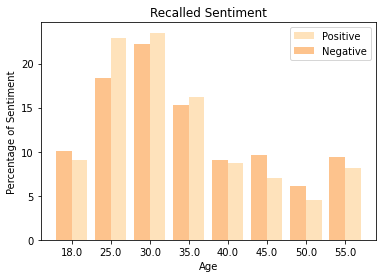

---------- Positive Stats ----------
Age: 18.0 Percentage: 9.019426456984274
Age: 25.0 Percentage: 22.849213691026826
Age: 30.0 Percentage: 23.496762257169287
Age: 35.0 Percentage: 16.23496762257169
Age: 40.0 Percentage: 8.741905642923218
Age: 45.0 Percentage: 7.030527289546716
Age: 50.0 Percentage: 4.4865864939870495
Age: 55.0 Percentage: 8.140610545790935
---------- Negative Stats ----------
Age: 18.0 Percentage: 10.084033613445378
Age: 25.0 Percentage: 18.319327731092436
Age: 30.0 Percentage: 22.18487394957983
Age: 35.0 Percentage: 15.294117647058824
Age: 40.0 Percentage: 9.07563025210084
Age: 45.0 Percentage: 9.57983193277311
Age: 50.0 Percentage: 6.050420168067227
Age: 55.0 Percentage: 9.411764705882353


In [205]:
X = newRecalled['annotatorAge'].unique()
X.sort()
x_axis = np.arange(len(newRecalled['annotatorAge'].unique()))


# Calculate Positive Amount and Percentages
positive = []
positive_total = 0
for x in X:
    value = len(newRecalled[(newRecalled['annotatorAge'] == x) & (newRecalled['sentiment'] == 'Positive')])
    positive.append(value)
    positive_total+=value

positive_percentage = []
for x in positive:
    positive_percentage.append((x/positive_total) * 100)


# Calculate Negative Amount and Percentages
negative = []
negative_total = 0
for x in X:
    value = len(newRecalled[(newRecalled['annotatorAge'] == x) & (newRecalled['sentiment'] == 'Negative')])
    negative.append(value)
    negative_total+=value

negative_percentage = []
for x in negative:
    negative_percentage.append((x/negative_total) * 100)

plt.xticks(x_axis, X)
plt.bar(x_axis + 0.2 ,positive_percentage,0.4,label='Positive')
plt.bar(x_axis - 0.2 ,negative_percentage,0.4,label='Negative')
plt.ylabel('Percentage of Sentiment')
plt.xlabel('Age')
plt.title('Recalled Sentiment')
plt.legend()
plt.show()

positive_stats = {}
negative_stats = {}
index = 0
for val in X:
    positive_stats[val] = positive_percentage[index]
    negative_stats[val] = negative_percentage[index]
    index+=1
print('---------- Positive Stats ----------')
for i in positive_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(positive_stats[i]))

print('---------- Negative Stats ----------')
for i in negative_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(negative_stats[i]))

From this graph we can see that...

C:\Users\kstev\AppData\Local\Temp\ipykernel_29908\2686234886.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_newRecalled['AgeGroup'] = pd.Categorical(pos_newRecalled['AgeGroup'], ['Youth','Adult','Senior'])
C:\Users\kstev\AppData\Local\Temp\ipykernel_29908\2686234886.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_newRecalled['AgeGroup'] = pd.Categorical(neg_newRecalled['AgeGroup'], ['Youth','Adult','Senior'])


Text(0.5, 1.0, 'Negative Sentiment Observations by Age Group')

<Figure size 7200x720 with 0 Axes>

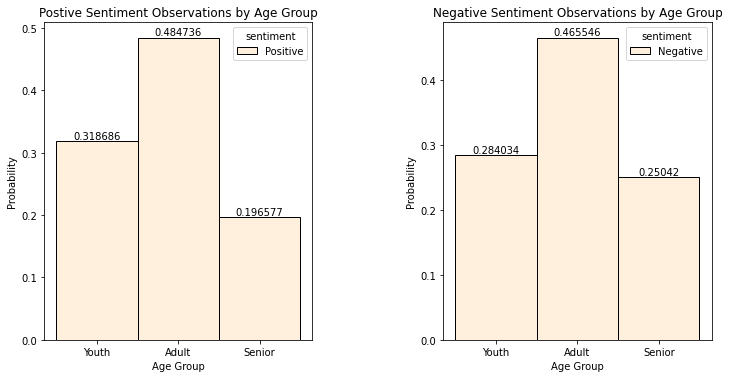

In [206]:
#separate data into positive and negative sentiments
pos_newRecalled = newRecalled.loc[newRecalled['sentiment'] == "Positive"]
neg_newRecalled = newRecalled.loc[newRecalled['sentiment'] == "Negative"]

#set figure and size
plt.figure(figsize=(100,10))
fig, axes = plt.subplots(1, 2,figsize=(10,5))
fig.tight_layout(w_pad = 10.0)

#Positive sentiment graph by age group
pos_newRecalled['AgeGroup'] = pd.Categorical(pos_newRecalled['AgeGroup'], ['Youth','Adult','Senior'])
pos_graph_2 = sns.histplot(data = pos_newRecalled, x="AgeGroup",hue = "sentiment", stat = 'probability', common_norm = 'false', ax=axes[0])
for container in pos_graph_2.containers:
    pos_graph_2.bar_label(container)

pos_graph_2.set(xlabel = 'Age Group')
axes[0].set_title("Postive Sentiment Observations by Age Group", fontsize=12)

#Negative sentiment graph by age group
neg_newRecalled['AgeGroup'] = pd.Categorical(neg_newRecalled['AgeGroup'], ['Youth','Adult','Senior'])
neg_graph_2 = sns.histplot(data = neg_newRecalled, x="AgeGroup", hue = "sentiment", stat = 'probability', common_norm = 'false', ax=axes[1])
for container in neg_graph_2.containers:
    neg_graph_2.bar_label(container)

neg_graph_2.set(xlabel = 'Age Group')
axes[1].set_title("Negative Sentiment Observations by Age Group")

Next, we will look at the number of positive, negative, and neutral sentiments between different age groups. We can see that both positive and negative sentiments follow the same trend: Adults with the most observations, followed by Senior, and finally Youth. 

# IV. Conclusion and Discussion

In [207]:
#Conclusion